Importing of relevant libraries

In [158]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal


import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


Feature Engineering

In [159]:
#loading the data into the environment 
data_raw = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
data_val  = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

data1 = data_raw.copy(deep = True)

data_cleaner = [data1, data_val]

In [160]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [161]:
data_raw.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [162]:
data_raw.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [163]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

Text(0.5, 1.0, 'Age group distribution')

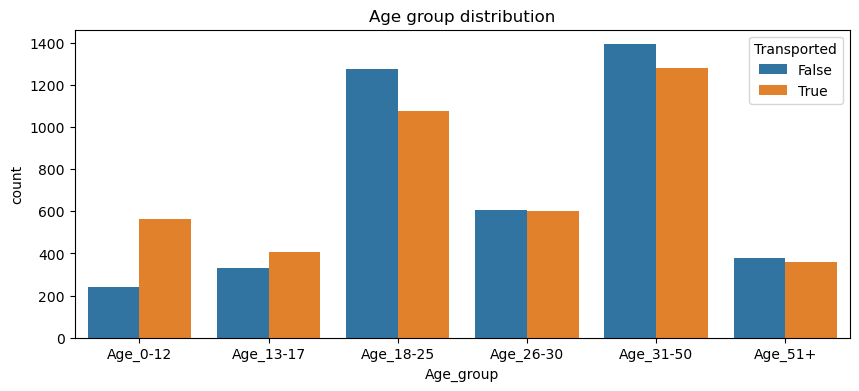

In [164]:
#Age group distribution
for dataset in data_cleaner: 
    dataset['Age_group']=np.nan
    dataset.loc[dataset['Age']<=12,'Age_group']='Age_0-12'
    dataset.loc[(dataset['Age']>12) & (dataset['Age']<18),'Age_group']='Age_13-17'
    dataset.loc[(dataset['Age']>=18) & (dataset['Age']<=25),'Age_group']='Age_18-25'
    dataset.loc[(dataset['Age']>25) & (dataset['Age']<=30),'Age_group']='Age_26-30'
    dataset.loc[(dataset['Age']>30) & (dataset['Age']<=50),'Age_group']='Age_31-50'
    dataset.loc[dataset['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=data1, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

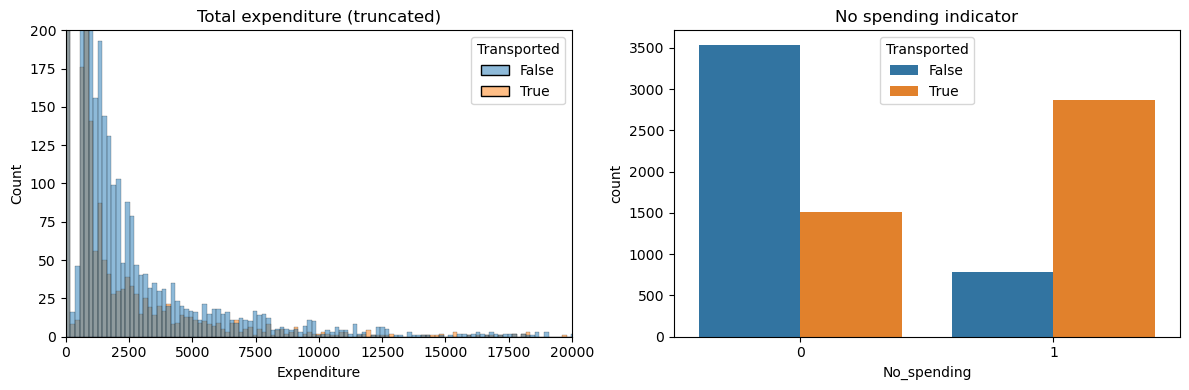

In [165]:
#Total Expenditure and No spending indicator
for dataset in data_cleaner: 
    dataset['Expenditure']=dataset[exp_feats].sum(axis=1)
    dataset['No_spending']=(dataset['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=data1, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=data1, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

/tmp/ipykernel_32/1957460683.py:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


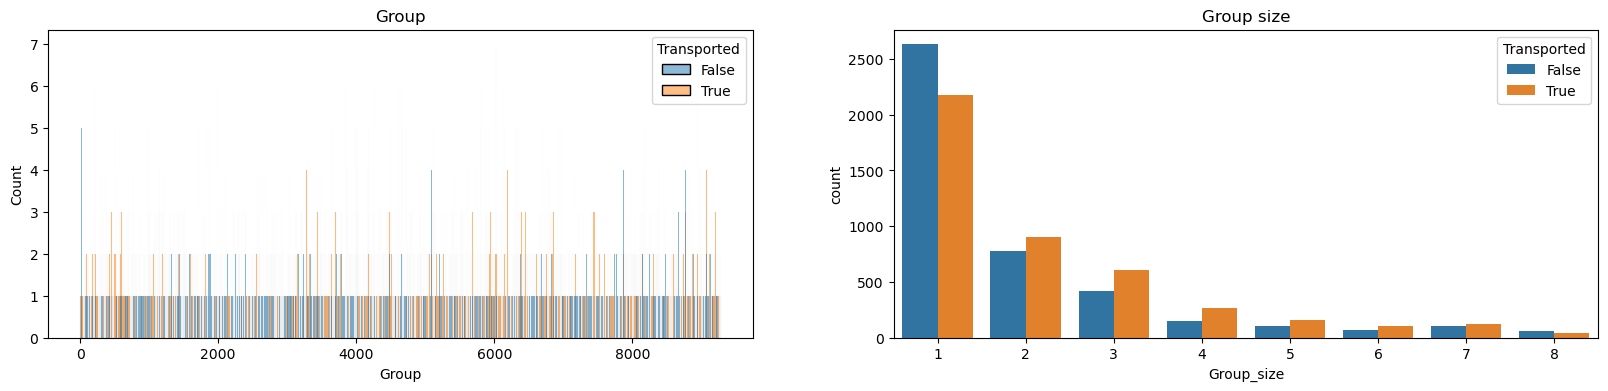

In [166]:
#Group and Group size 
for dataset in data_cleaner: 
    dataset['Group'] = dataset['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    dataset['Group_size']=dataset['Group'].map(lambda x: dataset['Group'].value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=data1, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=data1, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

(0.0, 3000.0)

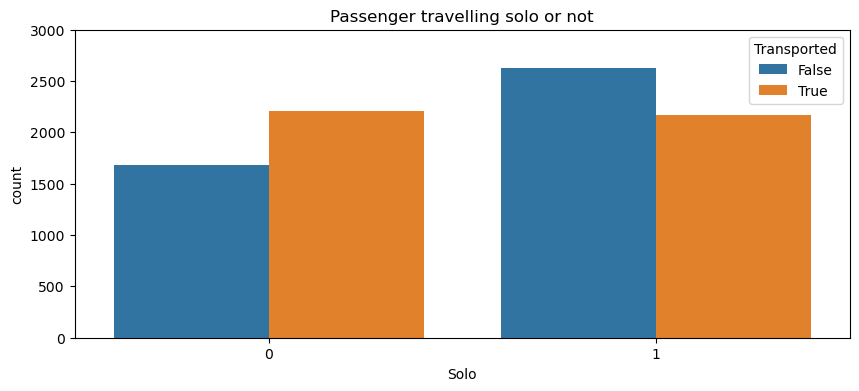

In [167]:
#The Group feature is not usable as it would explode the number of dimensions with one-hot encoding. Instead the feature can be further compressed
#into a 'Solo' column.
for dataset in data_cleaner: 
    dataset['Solo']=(dataset['Group_size']==1).astype(int)
    

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=data1, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

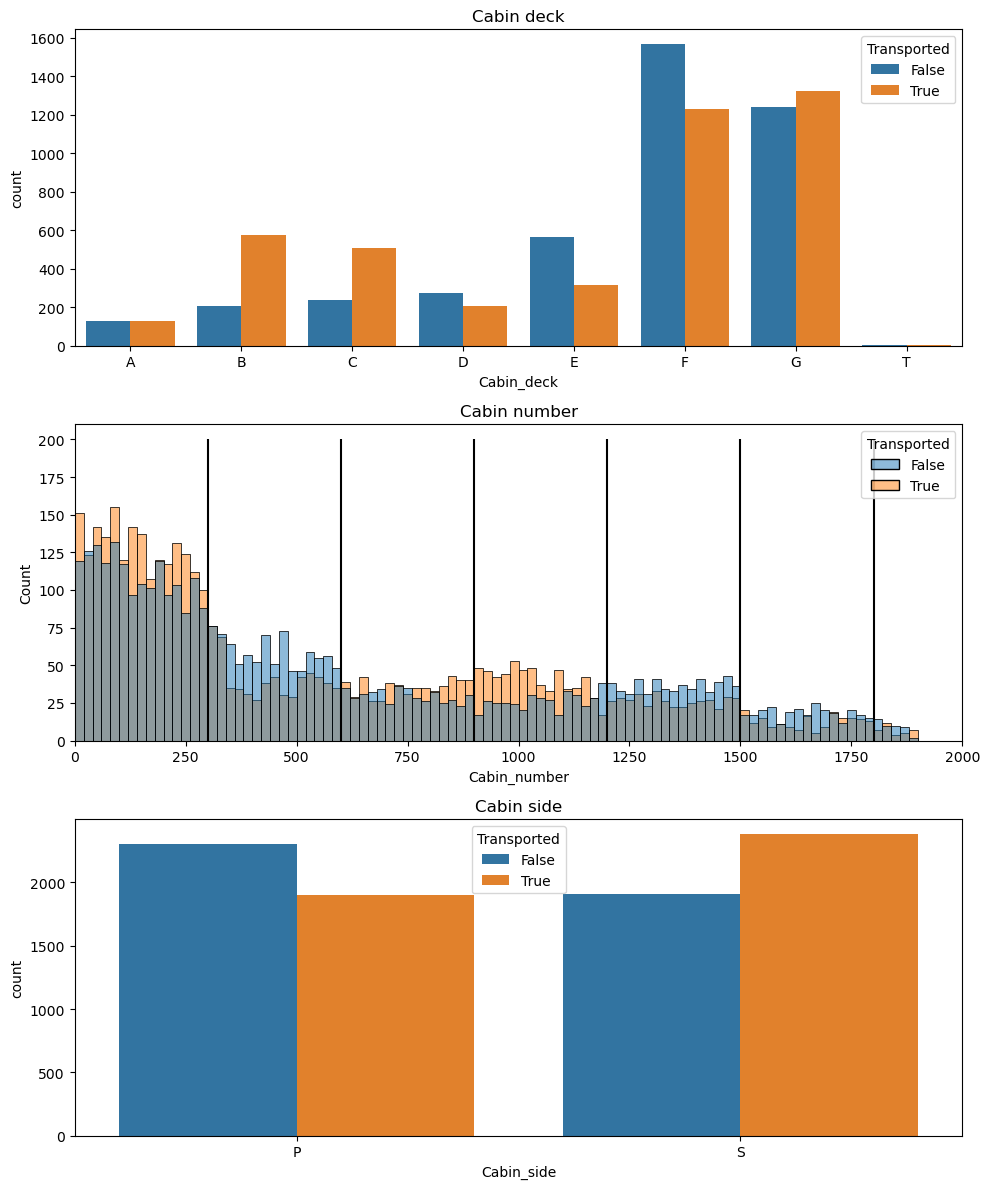

In [168]:
#Cabin Deck, Cabin Number and Cabin Side
for dataset in data_cleaner: 
    # Replace NaN's with outliers for now (so we can split feature)
    dataset['Cabin'].fillna('Z/9999/Z', inplace=True)
    # New features
    dataset['Cabin_deck'] = dataset['Cabin'].apply(lambda x: x.split('/')[0])
    dataset['Cabin_number'] = dataset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    dataset['Cabin_side'] = dataset['Cabin'].apply(lambda x: x.split('/')[2])
    
    # Put Nan's back in (we will fill these later)
    dataset.loc[dataset['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
    dataset.loc[dataset['Cabin_number']==9999, 'Cabin_number']=np.nan
    dataset.loc[dataset['Cabin_side']=='Z', 'Cabin_side']=np.nan
    
    # Drop Cabin (we don't need it anymore)
    dataset.drop('Cabin', axis=1, inplace=True)


# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=data1, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=data1, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=data1, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

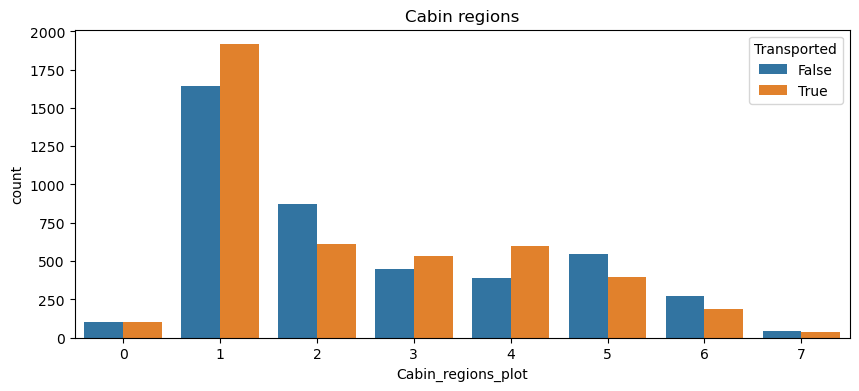

In [169]:
#Cabin Regions
for dataset in data_cleaner:
    # New features - training set
    dataset['Cabin_region1']=(dataset['Cabin_number']<300).astype(int)   # one-hot encoding
    dataset['Cabin_region2']=((dataset['Cabin_number']>=300) & (dataset['Cabin_number']<600)).astype(int)
    dataset['Cabin_region3']=((dataset['Cabin_number']>=600) & (dataset['Cabin_number']<900)).astype(int)
    dataset['Cabin_region4']=((dataset['Cabin_number']>=900) & (dataset['Cabin_number']<1200)).astype(int)
    dataset['Cabin_region5']=((dataset['Cabin_number']>=1200) & (dataset['Cabin_number']<1500)).astype(int)
    dataset['Cabin_region6']=((dataset['Cabin_number']>=1500) & (dataset['Cabin_number']<1800)).astype(int)
    dataset['Cabin_region7']=(dataset['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
data1['Cabin_regions_plot']=(data1['Cabin_region1']+2*data1['Cabin_region2']+3*data1['Cabin_region3']+4*data1['Cabin_region4']+5*data1['Cabin_region5']+6*data1['Cabin_region6']+7*data1['Cabin_region7']).astype(int)
sns.countplot(data=data1, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
data1.drop('Cabin_regions_plot', axis=1, inplace=True)

Text(0.5, 1.0, 'Family size')

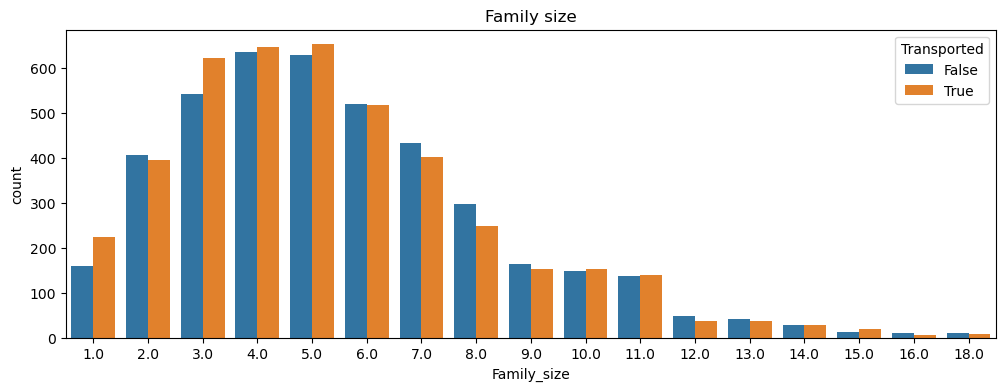

In [170]:
#Family Size
for dataset in data_cleaner:
    # Calculate family size from last name.
    # Replace NaN's with outliers for now (so we can split feature)
    dataset['Name'].fillna('Unknown Unknown', inplace=True)
    # New feature - Surname
    dataset['Surname']=dataset['Name'].str.split().str[-1]
    # New feature - Family size
    dataset['Family_size']=dataset['Surname'].map(lambda x: dataset['Surname'].value_counts()[x])
    # Put Nan's back in (we will fill these later)
    dataset.loc[dataset['Surname']=='Unknown','Surname']=np.nan
    dataset.loc[dataset['Family_size']>100,'Family_size']=np.nan
    # Drop name (we don't need it anymore)
    dataset.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=data1, x='Family_size', hue='Transported')
plt.title('Family size')

Data Cleaning 

In [171]:
for dataset in data_cleaner:
    GHP_gb=dataset.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
    # Missing values before
    HP_bef=dataset['HomePlanet'].isna().sum()

    # Passengers with missing HomePlanet and in a group with known HomePlanet
    GHP_index=dataset[dataset['HomePlanet'].isna()][(dataset[dataset['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

    # Fill corresponding missing values
    dataset.loc[GHP_index,'HomePlanet']=dataset.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

    # Print number of missing values left
    print('#HomePlanet missing values before:',HP_bef)
    print('#HomePlanet missing values after:',dataset['HomePlanet'].isna().sum())

# We managed to fill 131 values with 100% confidence but we are not finished yet.

#HomePlanet missing values before: 201
#HomePlanet missing values after: 111
#HomePlanet missing values before: 87
#HomePlanet missing values after: 46


In [172]:
'''
Notes:

Passengers on decks A, B, C or T came from Europa.
Passengers on deck G came from Earth.
Passengers on decks D, E or F came from multiple planets.
'''

for dataset in data_cleaner:
    # Missing values before
    HP_bef=dataset['HomePlanet'].isna().sum()

    # Decks A, B, C or T came from Europa
    dataset.loc[(dataset['HomePlanet'].isna()) & (dataset['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

    # Deck G came from Earth
    dataset.loc[(dataset['HomePlanet'].isna()) & (dataset['Cabin_deck']=='G'), 'HomePlanet']='Earth'

    # Print number of missing values left
    print('#HomePlanet missing values before:',HP_bef)
    print('#HomePlanet missing values after:',dataset['HomePlanet'].isna().sum())

#HomePlanet missing values before: 111
#HomePlanet missing values after: 63
#HomePlanet missing values before: 46
#HomePlanet missing values after: 31


In [173]:
for data in data_cleaner:
    SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
    #  Everyone with the same surname comes from the same home planet.
    # Missing values before
    HP_bef=data['HomePlanet'].isna().sum()

    # Passengers with missing HomePlanet and in a family with known HomePlanet
    SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

    # Fill corresponding missing values
    data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

    # Print number of missing values left
    print('#HomePlanet missing values before:',HP_bef)
    print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 63
#HomePlanet missing values after: 8
#HomePlanet missing values before: 31
#HomePlanet missing values after: 11


In [174]:
for data in data_cleaner:
    # Missing values before
    HP_bef=data['HomePlanet'].isna().sum()

    # Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
    data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
    data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

    # Print number of missing values left
    print('#HomePlanet missing values before:',HP_bef)
    print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

# We're done with HomePlanet.

#HomePlanet missing values before: 8
#HomePlanet missing values after: 0
#HomePlanet missing values before: 11
#HomePlanet missing values after: 0


In [175]:
for data in data_cleaner:
    # Missing values before
    D_bef=data['Destination'].isna().sum()

    # Fill missing Destination values with mode
    data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

    # Print number of missing values left
    print('#Destination missing values before:',D_bef)
    print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 182
#Destination missing values after: 0
#Destination missing values before: 92
#Destination missing values after: 0


In [176]:
for data in data_cleaner:
    # Joint distribution of Group and Surname
    GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

    # The majority (83%) of groups contain only 1 family. So let's fill missing surnames according to the majority surname in that group.
    # Missing values before
    SN_bef=data['Surname'].isna().sum()

    # Passengers with missing Surname and in a group with known majority Surname
    GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

    # Fill corresponding missing values
    data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

    # Print number of missing values left
    print('#Surname missing values before:',SN_bef)
    print('#Surname missing values after:',data['Surname'].isna().sum())

    # Replace NaN's with outliers (so we can use map)
    data['Surname'].fillna('Unknown', inplace=True)

    # Update family size feature
    data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

    # Put NaN's back in place of outliers
    data.loc[data['Surname']=='Unknown','Surname']=np.nan

    # Say unknown surname means no family
    data.loc[data['Family_size']>100,'Family_size']=0

#Surname missing values before: 200
#Surname missing values after: 104
#Surname missing values before: 94
#Surname missing values after: 51


In [177]:
for data in data_cleaner:
    # Joint distribution of Group and Cabin features
    GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
    GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
    GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

    # Everyone in the same group is also on the same cabin side. For cabin deck and cabin number there is also a fairly good (but not perfect) correlation with group.
    # Missing values before
    CS_bef=data['Cabin_side'].isna().sum()

    # Passengers with missing Cabin side and in a group with known Cabin side
    GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

    # Fill corresponding missing values
    data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

    # Print number of missing values left
    print('#Cabin_side missing values before:',CS_bef)
    print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 199
#Cabin_side missing values after: 99
#Cabin_side missing values before: 100
#Cabin_side missing values after: 63


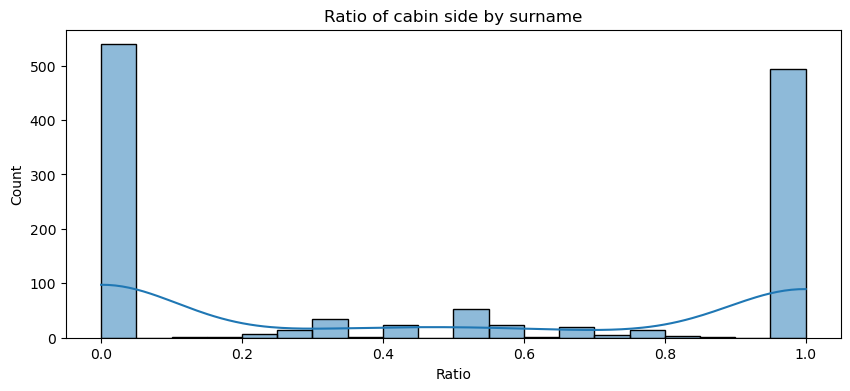

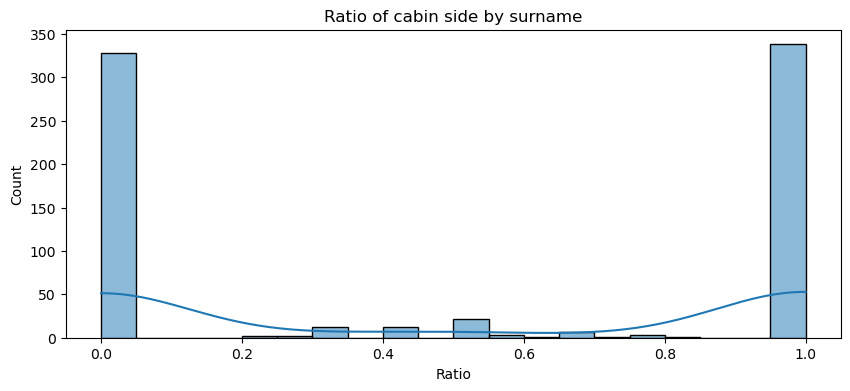

In [178]:
for data in data_cleaner:
    # Joint distribution of Surname and Cabin side
    SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

    # Ratio of sides
    SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

    # Histogram of ratio
    plt.figure(figsize=(10,4))
    sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
    plt.title('Ratio of cabin side by surname')

In [179]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 91.0 %


Cabin_side,P,S,Ratio
Surname,,,
Acobsond,3.0,0.0,1.0
Aginge,3.0,0.0,1.0
Aillyber,3.0,0.0,1.0
Aindlylid,0.0,1.0,0.0
Airdring,0.0,2.0,0.0


In [180]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)
    
for data in data_cleaner:
    # Passengers with missing Cabin side and in a family with known Cabin side
    SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

    # Fill corresponding missing values
    data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

    # Drop surname (we don't need it anymore)
    data.drop('Surname', axis=1, inplace=True)

    # Print number of missing values left
    print('#Cabin_side missing values before:',CS_bef)
    print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 63
#Cabin_side missing values after: 74
#Cabin_side missing values before: 63
#Cabin_side missing values after: 45


In [181]:
for data in data_cleaner:
    # Value counts
    data['Cabin_side'].value_counts()

    # Missing values before
    CS_bef=data['Cabin_side'].isna().sum()

    # Fill remaining missing values with outlier
    data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

    # Print number of missing values left
    print('#Cabin_side missing values before:',CS_bef)
    print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 74
#Cabin_side missing values after: 0
#Cabin_side missing values before: 45
#Cabin_side missing values after: 0


In [182]:
for data in data_cleaner:
    # Missing values before
    CD_bef=data['Cabin_deck'].isna().sum()

    # Passengers with missing Cabin deck and in a group with known majority Cabin deck
    GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

    # Fill corresponding missing values
    data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

    # Print number of missing values left
    print('#Cabin_deck missing values before:',CD_bef)
    print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 199
#Cabin_deck missing values after: 199
#Cabin_deck missing values before: 100
#Cabin_deck missing values after: 63


In [183]:
for data in data_cleaner:
    # Joint distribution
    data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
    '''
    Passengers from Mars are most likely in deck F.
    Passengers from Europa are (more or less) most likely in deck C if travelling solo and deck B otherwise.
    Passengers from Earth are (more or less) most likely in deck G.
    We will fill in missing values according to where the mode appears in these subgroups.
    '''
    # Missing values before
    CD_bef=data['Cabin_deck'].isna().sum()

    # Fill missing values using the mode
    na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
    data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

    # Print number of missing values left
    print('#Cabin_deck missing values before:',CD_bef)
    print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 199
#Cabin_deck missing values after: 0
#Cabin_deck missing values before: 63
#Cabin_deck missing values after: 0


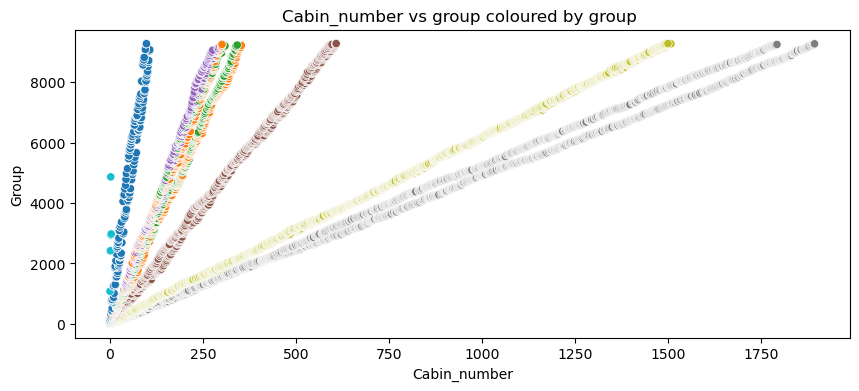

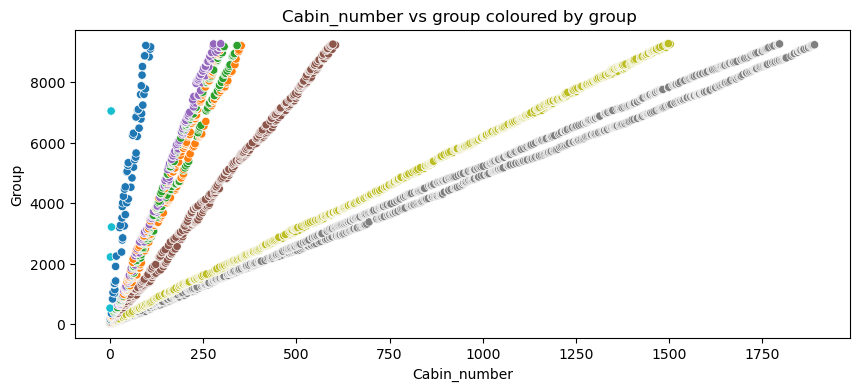

In [184]:
for data in data_cleaner:
    # Scatterplot
    plt.figure(figsize=(10,4))
    sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
    plt.title('Cabin_number vs group coloured by group ')

In [185]:
for data in data_cleaner:
    # Missing values before
    CN_bef=data['Cabin_number'].isna().sum()
    print('#Cabin_number missing values before:',CN_bef)
    # Extrapolate linear relationship on a deck by deck basis
    for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        # Features and labels
        X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
        y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
        X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

        if not X_test_CN.empty:
            # Linear regression
            model_CN=sklearn.linear_model.LinearRegression()
            model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
            preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

            # Fill missing values with predictions
            data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

    # Print number of missing values left
    print('#Cabin_number missing values before:',CN_bef)
    print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

    # One-hot encode cabin regions
    data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
    data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
    data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
    data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
    data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
    data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
    data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

#Cabin_number missing values before: 199
#Cabin_number missing values before: 199
#Cabin_number missing values after: 0
#Cabin_number missing values before: 100
#Cabin_number missing values before: 100
#Cabin_number missing values after: 0


In [186]:
for data in data_cleaner:
    # Missing values before
    V_bef=data['VIP'].isna().sum()

    # Fill missing values with mode
    data.loc[data['VIP'].isna(),'VIP']=False

    # Print number of missing values left
    print('#VIP missing values before:',V_bef)
    print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 203
#VIP missing values after: 0
#VIP missing values before: 93
#VIP missing values after: 0


In [187]:
for data in data_cleaner:
    # Joint distribution
    data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)
    # Missing values before
    A_bef=data[exp_feats].isna().sum().sum()

    # Fill missing values using the median
    na_rows_A=data.loc[data['Age'].isna(),'Age'].index
    data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

    # Print number of missing values left
    print('#Age missing values before:',A_bef)
    print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 943
#Age missing values after: 0
#Age missing values before: 467
#Age missing values after: 0


In [188]:
for data in data_cleaner:
    # Update age group feature
    data.loc[data['Age']<=12,'Age_group']='Age_0-12'
    data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
    data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
    data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
    data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
    data.loc[data['Age']>50,'Age_group']='Age_51+'

In [189]:
for data in data_cleaner:
    # Joint distribution
    data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)
    # Missing values before
    CSL_bef=data['CryoSleep'].isna().sum()

    # Fill missing values using the mode
    na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
    data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

    # Print number of missing values left
    print('#CryoSleep missing values before:',CSL_bef)
    print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 217
#CryoSleep missing values after: 0
#CryoSleep missing values before: 93
#CryoSleep missing values after: 0


In [190]:
for data in data_cleaner:
    # Missing values before
    E_bef=data[exp_feats].isna().sum().sum()

    # CryoSleep has no expenditure
    for col in exp_feats:
        data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

    # Print number of missing values left
    print('#Expenditure missing values before:',E_bef)
    print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 943
#Expenditure missing values after: 571
#Expenditure missing values before: 467
#Expenditure missing values after: 295


In [191]:
for data in data_cleaner:
    # Joint distribution
    data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)
    # Missing values before
    E_bef=data[exp_feats].isna().sum().sum()

    # Fill remaining missing values using the median
    for col in exp_feats:
        na_rows=data.loc[data[col].isna(),col].index
        data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

    # Print number of missing values left
    print('#Expenditure missing values before:',E_bef)
    print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 571
#Expenditure missing values after: 0
#Expenditure missing values before: 295
#Expenditure missing values after: 0


In [192]:
for data in data_cleaner:
    # Update expenditure and no_spending
    data['Expenditure']=data[exp_feats].sum(axis=1)
    data['No_spending']=(data['Expenditure']==0).astype(int)
    data.isna().sum()
    # Apply log transform
    for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
        data[col]=np.log(1+data[col])

Data Formatting and Splitting

In [193]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()

for data in data_cleaner:

    data['HomePlanet_Code'] = label.fit_transform(data['HomePlanet'])
    data['CryoSleep_Code'] = label.fit_transform(data['CryoSleep'])
    data['Destination_Code'] = label.fit_transform(data['Destination'])
    data['VIP_Code'] = label.fit_transform(data['VIP'])
    data['Age_group_Code'] = label.fit_transform(data['Age_group'])
    data['Cabin_deck_Code'] = label.fit_transform(data['Cabin_deck'])
    data['Cabin_side_Code'] = label.fit_transform(data['Cabin_side'])

In [194]:
# define y variable aka target/outcome
Target = ['Transported']

# define x variables for original features aka feature selection

# 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
data1_x = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] # Original data
# 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Family_size', 'HomePlanet_Code', 'CryoSleep_Code', 'Destination_Code', 'VIP_Code', 'Age_group_Code', 'Cabin_deck_Code', 'Cabin_side_Code'

data1_x_calc = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'No_spending', 'Group', 'Group_size', 'Solo', 'Cabin_number', 'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Family_size', 'HomePlanet_Code', 'CryoSleep_Code', 'Destination_Code', 'VIP_Code', 'Age_group_Code', 'Cabin_deck_Code', 'Cabin_side_Code'] # coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


# define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Age', 'No_spending', 'Group_size', 'Solo', 'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Family_size', 'HomePlanet_Code', 'CryoSleep_Code', 'Destination_Code', 'VIP_Code', 'Age_group_Code', 'Cabin_deck_Code', 'Cabin_side_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Transported', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 

Bin X Y:  ['Transported', 'Age', 'No_spending', 'Group_size', 'Solo', 'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Family_size', 'HomePlanet_Code', 'CryoSleep_Code', 'Destination_Code', 'VIP_Code', 'Age_group_Code', 'Cabin_deck_Code', 'Cabin_side_Code'] 

Dummy X Y:  ['Transported', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True'] 



,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,1,0,0,0,1,1,0
1,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,1,0,0,1,0,0,0,1,1,0
2,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,0,1,0,1,0,0,0,1,0,1
3,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,0,1,0,1,0,0,0,1,1,0
4,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,1,0,0,1,0,0,0,1,1,0


In [195]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values: 
 PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported         0
Age_group           0
Expenditure         0
No_spending         0
Group               0
Group_size          0
Solo                0
Cabin_deck          0
Cabin_number        0
Cabin_side          0
Cabin_region1       0
Cabin_region2       0
Cabin_region3       0
Cabin_region4       0
Cabin_region5       0
Cabin_region6       0
Cabin_region7       0
Family_size         0
HomePlanet_Code     0
CryoSleep_Code      0
Destination_Code    0
VIP_Code            0
Age_group_Code      0
Cabin_deck_Code     0
Cabin_side_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtyp

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [196]:
#split train and test data with function defaults
#random_state 
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (8693, 36)
Train1 Shape: (6519, 27)
Test1 Shape: (2174, 27)


,Age,No_spending,Group_size,Solo,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size,HomePlanet_Code,CryoSleep_Code,Destination_Code,VIP_Code,Age_group_Code,Cabin_deck_Code,Cabin_side_Code
5020,37.0,1,1,1,0,0,0,1,0,0,0,4,2,1,2,0,4,5,0
5967,44.0,1,3,0,0,0,0,1,0,0,0,7,0,1,0,0,4,6,1
991,27.0,0,1,1,1,0,0,0,0,0,0,2,0,0,1,0,3,5,1
2894,15.0,0,1,1,0,1,0,0,0,0,0,6,0,0,0,0,1,6,0
2228,23.0,0,1,1,0,1,0,0,0,0,0,3,2,0,2,0,2,5,1


**Modeling the data and Hyperparameter Tuning **

In [197]:
#Creating a Function to build a Keras Deep Learning Model using the Sequential API
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[27]):
 model = keras.models.Sequential()
 model.add(keras.layers.InputLayer(input_shape=input_shape))
 for layer in range(n_hidden):
     model.add(keras.layers.Dense(n_neurons, activation="selu",kernel_initializer='lecun_normal'))
 model.add(keras.layers.Dense(1, activation='sigmoid'))
 optimizer = keras.optimizers.RMSprop(lr=learning_rate)
 model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])
 return model

In [198]:
#Wrapping the build_model function so that it behaves like a Sklearn Classifier
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

/tmp/ipykernel_32/3912641848.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [199]:
#RandomizedSearchCV to find the best hyperparameter(number of layers and neurons)
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
 "n_hidden": [1, 2, 3, 4, 5],
 "n_neurons": [50, 100, 200, 300, 400, 500],
 "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(train1_x, train1_y, epochs=50, validation_data=(test1_x, test1_y)
                  ,callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
136/136 [==============================] - 1s 4ms/step - loss: 28.8219 - accuracy: 0.5278 - val_loss: 10.4791 - val_accuracy: 0.5161
Epoch 2/50
136/136 [==============================] - 0s 2ms/step - loss: 17.4554 - accuracy: 0.5117 - val_loss: 16.2302 - val_accuracy: 0.5097
Epoch 3/50
136/136 [==============================] - 0s 2ms/step - loss: 9.3703 - accuracy: 0.5166 - val_loss: 4.1336 - val_accuracy: 0.4995
Epoch 4/50
136/136 [==============================] - 0s 3ms/step - loss: 3.8264 - accuracy: 0.5131 - val_loss: 1.5492 - val_accuracy: 0.5336
Epoch 5/50
136/136 [==============================] - 0s 2ms/step - loss: 1.5153 - accuracy: 0.5594 - val_loss: 0.7086 - val_accuracy: 0.5285
Epoch 6/50
136/136 [==============================] - 0s 3ms/step - loss: 0.7806 - accuracy: 0.5437 - val_loss: 0.8796 - val_accuracy: 0.5731
Epoch 7/50
136/136 [==============================] - 0s 2ms/step - loss: 0.7405 - accuracy: 0.5320 - val_loss: 0.7622 - val_accuracy: 0.5354
Ep

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ef92064d390>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ef918dd4400>,
                                        'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': [50, 100, 200, 300, 400,
                                                      500]})

In [200]:
rnd_search_cv.best_params_


{'learning_rate': 0.00889754019574358, 'n_hidden': 3, 'n_neurons': 50}

In [201]:
rnd_search_cv.best_score_

0.6695812145868937

In [202]:
#Allowing the reproducability of similar hidden layers
from functools import partial 

Dense = partial(keras.layers.Dense, 
               activation = 'selu',
               kernel_initializer='lecun_normal')

In [203]:
#Building of Model based on the best params 
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=27),
    Dense(200),
    Dense(200),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(1, activation="sigmoid")])

In [204]:
model.summary()

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_496 (Dense)           (None, 200)               5600      
                                                                 
 dense_497 (Dense)           (None, 200)               40200     
                                                                 
 alpha_dropout_2 (AlphaDropo  (None, 200)              0         
 ut)                                                             
                                                                 
 dense_498 (Dense)           (None, 1)                 201       
                                                                 
Total params: 46,001
Trainable params: 46,001
Non-trainable params: 0
_________________________________________________________________


In [205]:
#Instantiating the callbacks 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [206]:
model.compile(loss="binary_crossentropy",
 optimizer='RMSprop',
 metrics=["accuracy"])

In [207]:
 history = model.fit(train1_x, train1_y, epochs=50, validation_data=(test1_x, test1_y), 
                     callbacks=[lr_scheduler,early_stopping_cb,checkpoint_cb])

Epoch 1/50
204/204 [==============================] - 1s 4ms/step - loss: 77.7593 - accuracy: 0.5084 - val_loss: 13.1614 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 2/50
204/204 [==============================] - 1s 3ms/step - loss: 11.7037 - accuracy: 0.5266 - val_loss: 0.7294 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 3/50
204/204 [==============================] - 1s 3ms/step - loss: 1.2030 - accuracy: 0.5157 - val_loss: 0.9561 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 4/50
204/204 [==============================] - 1s 3ms/step - loss: 1.0028 - accuracy: 0.5099 - val_loss: 0.7182 - val_accuracy: 0.5120 - lr: 0.0010
Epoch 5/50
204/204 [==============================] - 1s 3ms/step - loss: 1.0102 - accuracy: 0.5134 - val_loss: 0.6982 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 6/50
204/204 [==============================] - 1s 3ms/step - loss: 0.9560 - accuracy: 0.5148 - val_loss: 0.8866 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 7/50
204/204 [==============================] - 1s 3ms/step -